# Unexpected Failures Logs

In a different notebook we characterized certain failures as "unexpected". We additionally came up with a simple metric to classify a test run, i.e. a column in TestGrid, as "unexpected". In this notebook we will look at the log data and see what happens in unexpected test failures, and see if these failures are the ones that persist in the unexpected columns.

In [32]:
import requests
import json
import pandas as pd
import numpy as np
import datetime
from bs4 import BeautifulSoup
import os
import seaborn as sns
from google.cloud import storage
from IPython.display import Image
import matplotlib.pyplot as plt
from collections import Counter

import sys
sys.path.append('../../failure-type-classification')
sys.path.append('./metrics')


from ipynb.fs.defs.failure_type_functions import ( #noqa
    normalize, #noqa
    decode_run_length, #noqa
)

from ipynb.fs.defs.unexpected_test_failures import ( #noqa
    naive_prob_failure, #noqa
    get_grid, #noqa
    preprocess, # noqa
    column_scores, # noqa
    column_score, # noqa
    random_trial, # noqa
    score_grid, # noqa
)

In [3]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)

In [4]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names = [d[1: -1] for d in dashboard_names]
dashboard_names

['redhat-assisted-installer',
 'redhat-hypershift',
 'redhat-openshift-informing',
 'redhat-openshift-ocp-release-3.11-informing',
 'redhat-openshift-ocp-release-4.1-blocking',
 'redhat-openshift-ocp-release-4.1-informing',
 'redhat-openshift-ocp-release-4.10-blocking',
 'redhat-openshift-ocp-release-4.10-broken',
 'redhat-openshift-ocp-release-4.10-informing',
 'redhat-openshift-ocp-release-4.2-blocking',
 'redhat-openshift-ocp-release-4.2-informing',
 'redhat-openshift-ocp-release-4.3-blocking',
 'redhat-openshift-ocp-release-4.3-informing',
 'redhat-openshift-ocp-release-4.4-blocking',
 'redhat-openshift-ocp-release-4.4-broken',
 'redhat-openshift-ocp-release-4.4-informing',
 'redhat-openshift-ocp-release-4.5-blocking',
 'redhat-openshift-ocp-release-4.5-broken',
 'redhat-openshift-ocp-release-4.5-informing',
 'redhat-openshift-ocp-release-4.6-blocking',
 'redhat-openshift-ocp-release-4.6-informing',
 'redhat-openshift-ocp-release-4.7-blocking',
 'redhat-openshift-ocp-release-4.7-in

In [6]:
data_dict = {}
for d in dashboard_names:
    print(d)
    response = requests.get(f"https://testgrid.k8s.io/{d}/summary")
    data = response.json()
    ocp42 = pd.DataFrame(data)
    jobs = ocp42.columns
    dashboard_dict = {}
    for j in jobs:
        response = requests.get(f'https://testgrid.k8s.io/{d}/table?&show-stale-tests=&tab={j}')
        grid = []
        if response.json()["tests"]:
            for x in response.json()["tests"]:
                test = {"name": x["name"], "statuses": x["statuses"]}
                if "graphs" in x.keys():
                    test["graphs"] = x["graphs"]
                else:
                    test["graphs"] = None
                grid.append(test)
            x = np.array(list(pd.DataFrame(grid).statuses.apply(decode_run_length)))
            x = pd.DataFrame(x).apply(lambda x: [normalize(y) for y in x])
            changelists = response.json()['changelists']
            dashboard_dict[j] = {'grid': x, 'timestamps': changelists}
        else:
            continue
    data_dict[d] = dashboard_dict

redhat-assisted-installer
redhat-hypershift
redhat-openshift-informing
redhat-openshift-ocp-release-3.11-informing
redhat-openshift-ocp-release-4.1-blocking
redhat-openshift-ocp-release-4.1-informing
redhat-openshift-ocp-release-4.10-blocking
redhat-openshift-ocp-release-4.10-broken
redhat-openshift-ocp-release-4.10-informing
redhat-openshift-ocp-release-4.2-blocking
redhat-openshift-ocp-release-4.2-informing
redhat-openshift-ocp-release-4.3-blocking
redhat-openshift-ocp-release-4.3-informing
redhat-openshift-ocp-release-4.4-blocking
redhat-openshift-ocp-release-4.4-broken
redhat-openshift-ocp-release-4.4-informing
redhat-openshift-ocp-release-4.5-blocking
redhat-openshift-ocp-release-4.5-broken
redhat-openshift-ocp-release-4.5-informing
redhat-openshift-ocp-release-4.6-blocking
redhat-openshift-ocp-release-4.6-informing
redhat-openshift-ocp-release-4.7-blocking
redhat-openshift-ocp-release-4.7-informing
redhat-openshift-ocp-release-4.8-blocking
redhat-openshift-ocp-release-4.8-broken


In [7]:
response = requests.get(f'https://testgrid.k8s.io/redhat-osd/table?&show-stale-tests=&tab=osde2e-prod-gcp-e2e-upgrade-to-next-z')

In [8]:
grid = []
for x in response.json()["tests"]:
    test = {"name": x["name"], "statuses": x["statuses"]}
    if "graphs" in x.keys():
        test["graphs"] = x["graphs"]
    else:
        test["graphs"] = None
    grid.append(test)

In [9]:
def get_random_dashboard():
    dashboard = np.random.choice(list(data_dict.keys()))
    job = np.random.choice(list(data_dict[dashboard].keys()))
    return dashboard, job

In [10]:
# taken from data-sources/gcsweb-ci/build-logs/build_log_EDA.ipynb

client = storage.client.Client.create_anonymous_client()
bucket = client.bucket("origin-ci-test")

In [11]:
def prow_url_for(job, build_id):
        return f"https://prow.ci.openshift.org/view/gcs/origin-ci-test/logs/{job}/{build_id}"
    
def build_log_url_for(job, build_id):
    """Returns a public URL to download a build's build-log.txt"""
    blob = bucket.get_blob(f"logs/{job}/{build_id}/build-log.txt")
    return blob.public_url

def testgrid_url(dash, job):
    return f"https://testgrid.k8s.io/{dash}#{job}"

In [12]:
dash, job = get_random_dashboard()

print(dash)
print(job)

redhat-openshift-okd-release-4.8-blocking
periodic-ci-openshift-release-master-okd-4.8-e2e-aws


In [13]:
grid = data_dict[dash][job]['grid']
grid.head(5)

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1.0,1.0,0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [14]:
# check to see if testgrid data more or less matches

testgrid_url(dash, job)

'https://testgrid.k8s.io/redhat-openshift-okd-release-4.8-blocking#periodic-ci-openshift-release-master-okd-4.8-e2e-aws'

In [15]:
scores = score_grid(grid)

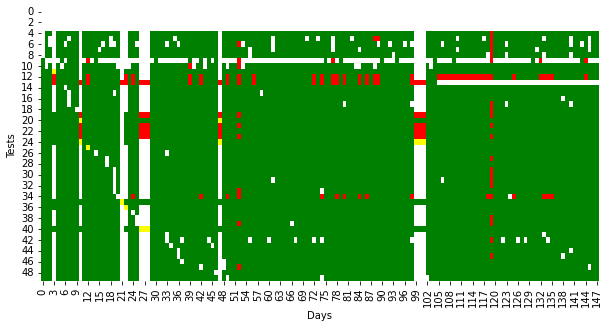

In [16]:
get_grid(grid)

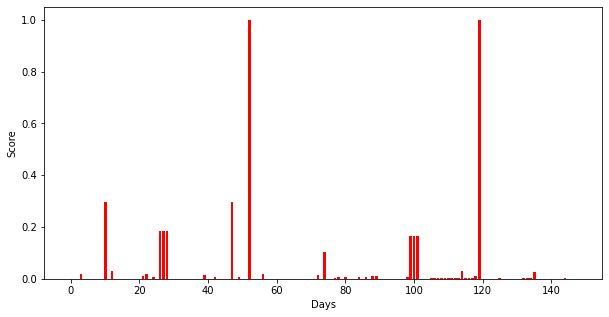

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(x = grid.columns, height = scores, color = 'r', alpha = 0.5)
plt.ylabel("Score")
plt.xlabel("Days")
plt.show()

In [19]:
tstamps = data_dict[dash][job]['timestamps']

In [20]:
# look at only the errors
error_lines = []
log_lines = []

for tstamp in tstamps:
    r = requests.get(build_log_url_for(job, tstamp))
    line_list = r.text.split('\n')
    log_lines.append(line_list)
    line_list = [line for line in line_list if 'error' in line.lower()]
    error_lines.append(line_list)

In [21]:
[len(l) for l in error_lines]

[0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 70,
 0,
 815,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 860,
 0,
 53,
 53,
 53,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 824,
 0,
 0,
 858,
 0,
 0,
 0,
 0,
 68,
 0,
 934,
 0,
 0,
 3522,
 0,
 0,
 0,
 895,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 809,
 0,
 852,
 0,
 0,
 848,
 865,
 0,
 869,
 0,
 2,
 0,
 993,
 0,
 778,
 0,
 761,
 773,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 819,
 49,
 49,
 49,
 0,
 0,
 0,
 1655,
 1693,
 1616,
 1672,
 1604,
 1620,
 1634,
 1617,
 1649,
 1648,
 1648,
 1608,
 1666,
 1666,
 15615,
 0,
 0,
 0,
 0,
 0,
 1671,
 0,
 0,
 0,
 0,
 0,
 0,
 1654,
 1670,
 1771,
 1649,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1619,
 0,
 0,
 0]

In [204]:
from collections import Counter

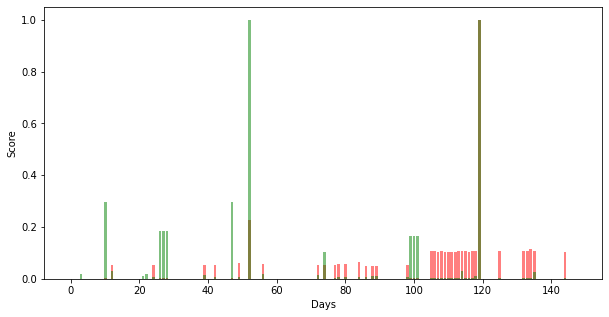

In [29]:
line_lens = np.array([len(l) for l in error_lines])
line_lens = (line_lens - min(line_lens))/max(line_lens)

plt.figure(figsize=(10, 5))
plt.bar(x = grid.columns, height = line_lens, color = 'r', alpha = 0.5)
plt.bar(x = grid.columns, height = scores, color = 'g', alpha = 0.5)
plt.ylabel("Score")
plt.xlabel("Days")
plt.show()

At first when doing this analysis I started to think the "unexpectedness" metric was useless due to the very heavy overlap between the unexpectedness score and the number of error lines. However, this changed when I saw this graph. The red is the number of error lines in a log (min-max scaled), and the green is the scores themselves. Something interesting is definitely happening at the two parts that have high score, and now we know that the little red bars are not signaling anything anomolous at all.

In [31]:
letters = [chr(char) for char in range(ord('a'), ord('z') + 1)]

In [33]:
def get_letters_vector(error_line):
    c = Counter(error_line)
    return np.array([c[letter] for letter in letters])

In [40]:
list1, list2 = error_lines[52], error_lines[119]

In [233]:
# the goal is to compare the errors and see how many overlapping characters they have

In [41]:
len(list1)

3522

In [42]:
len(list2)

15615

In [43]:
list1_counts = [get_letters_vector(l) for l in list1]
list2_counts = [get_letters_vector(l) for l in list2]

<AxesSubplot:ylabel='Count'>

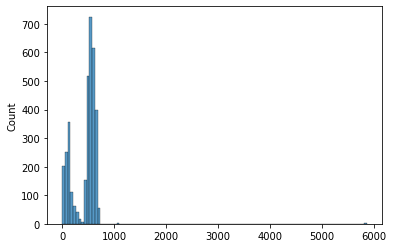

In [44]:
sns.histplot([sum(l) for l in list1_counts])

<AxesSubplot:ylabel='Count'>

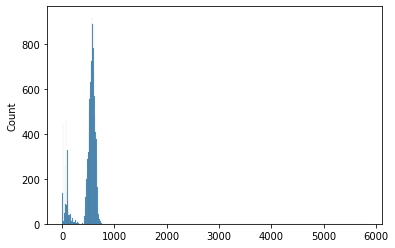

In [45]:
sns.histplot([sum(l) for l in list2_counts])

It's interesting to see that the distributions are shaped about the same here. Maybe expected due to the large sample sizes.